# Pneumonia Detection

This purpose of this notebook is to build a model that is proficient at detecting pneumonia given x-ray images. The data was taken from Kaggle and has three different folders, each with two classes: there is a test, train, and validation folder that has images of class NORMAL and PNEUMONIA. While the x-ray images look grayscale, they are stil 3 channel and need to be treated as such in order for the model to work properly.

The validation folder only housed about a total of 16 images between both NORMAL and PNEUMONIA classes. As such, I decided to move approximately 84 images from the train set over to the validation set. This resulted in 5040 images in the train folder, 624 images in the test folder, and 192 images in the validation folder. There was also an imbalance in the classes, with the PNEUMONIA class having almost 3 times as many instances as the NORMAl class in the train folder. To combat this, data augmentation was randomly done to images during training. 

Initially the models were custom made, with the make up of layers and the number of layers determined by me. The first 3 models were custom, which performed well, but were still overfitting on the training set. Ultimately, for the 4th model, VGG16 was used with imagenet weights and that performed the best, with validation accuracy and train accuracy being very close to one another. Each model was evaluated against the validation set while it trained and ultimately evaluated against the test set. Each model had graphs that modeled the accuracy and loss across each epoch, which made it easy to determine which ones performed well and which ones didn't. 

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.regularizers import L2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
#import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

We will load all the images from the train, val, and test folders. With flow_from_directory, the images will have the labels attached so we do not need to specify the labels.

I have also moved some of the train images into the val folder since there was a pretty large imbalance. There were only around 10 images in the validation set.

In [8]:
#Change batch size depending on scenario
b_size = 32 

train_data = ImageDataGenerator(rescale=1/255)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(224,224), batch_size=b_size, class_mode='binary', shuffle=True)
#train_labels = to_categorical(train_img.labels, num_classes=2)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)
#val_labels = to_categorical(val_img.labels, num_classes=2)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)
#test_labels = to_categorical(test_img.labels, num_classes=2)
print(train_img.class_indices)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


After tinkering with the data, it seems that include 'class_mode=binary' in the flow from directory function caused the model to work properly. Without it, the test accuracy and validation accuracy was exactly 0.5 for each epoch.

# Model 1
Here we will make a pretty shallow network to see how well it will work. Despite the images looking like grayscale, they are still 3 channel(rgb).

In [9]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3), groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_hist = model.fit(train_img, 
                       epochs=10, 
                       validation_data=val_img, 
                       steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 36s 240ms/step - loss: 0.4548 - accuracy: 0.9404 - val_loss: 24.0668 - val_accuracy: 0.5000
Epoch 2/10
150/150 [==============================] - 35s 235ms/step - loss: 0.0612 - accuracy: 0.9797 - val_loss: 4.7419 - val_accuracy: 0.5052
Epoch 3/10
150/150 [==============================] - 35s 235ms/step - loss: 0.0451 - accuracy: 0.9818 - val_loss: 3.0555 - val_accuracy: 0.5104
Epoch 4/10
150/150 [==============================] - 35s 233ms/step - loss: 0.0331 - accuracy: 0.9883 - val_loss: 3.6355 - val_accuracy: 0.5625
Epoch 5/10
150/150 [==============================] - 35s 232ms/step - loss: 0.0203 - accuracy: 0.9925 - val_loss: 5.0653 - val_accuracy: 0.5833
Epoch 6/10
150/150 [==============================] - 35s 234ms/step - loss: 0.0220 - accuracy: 0.9895 - val_loss: 0.1505 - val_accuracy: 0.9583
Epoch 7/10
150/150 [==============================] - 35s 236ms/step - loss: 0.0521 - accuracy: 0.9866 - val_loss: 62.6565 - val_

When we evaluate on the test set, we see that the accuracy is not too great, sitting at just above 60 percent.

In [11]:
model.evaluate(test_img)

20/20 [==============================] - 9s 433ms/step - loss: 6.6874 - accuracy: 0.6346


[6.687426567077637, 0.6346153616905212]

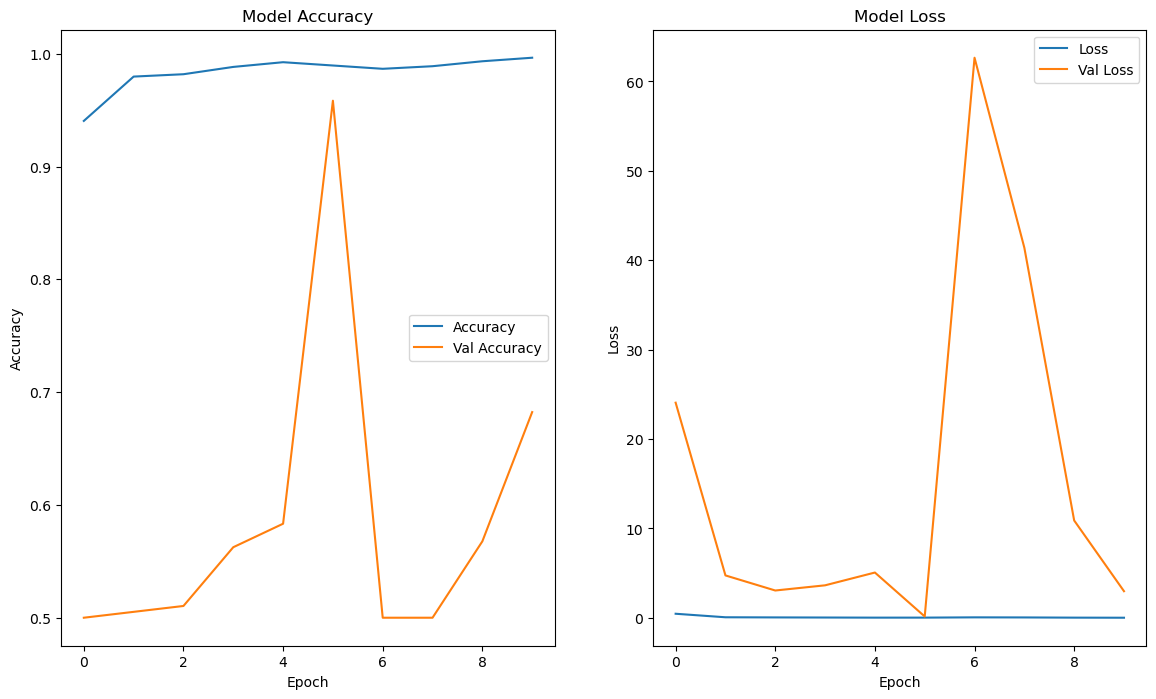

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(14, 8))

ax1.plot(model_hist.history['accuracy'])
ax1.plot(model_hist.history['val_accuracy'])
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2.plot(model_hist.history['loss'])
ax2.plot(model_hist.history['val_loss'])
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch');

When we graph the results, we can see that the accuracy is all over the place. While the model is getting good accuracy on the train set, it is overfitting incredibly hard. The validation accuracy is considerably lower than than the train accuracy, save for one epoch where it randomly spiked up.


# Model 2
We will try to fix this and improve the test accuracy by adding deeper layers. We will also bath normalize and add dropout to the layers.

I will also augment some of the images when we pull them in to prevent overfitting and potentially help more with the imbalance in the data

In [17]:
#Change batch size depending on scenario
b_size = 32 

train_data = ImageDataGenerator(rescale=1/255, rotation_range=30, zoom_range=0.2, horizontal_flip=True,
                                width_shift_range=0.2, height_shift_range=0.2)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(224,224), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3), groups=1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', groups=1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', groups=1))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(units=1, activation='sigmoid'))

We will monitor the accuracy and decrease learning rate if the accuracy plateaus. We will also start with a lower learning rate to start off with to see if the model will learn better.

In [19]:
optimizer = keras.optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=4)

model2.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model2_hist = model2.fit(train_img, epochs=10, validation_data=val_img, steps_per_epoch=5040/b_size, callbacks=[reduce_lr, early_stop])

c:\Users\Eddie\anaconda3\envs\gpuenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
157/157 [==============================] - 72s 454ms/step - loss: 0.3487 - accuracy: 0.8611 - val_loss: 10.4938 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/10
157/157 [==============================] - 71s 446ms/step - loss: 0.2403 - accuracy: 0.9018 - val_loss: 14.9434 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/10
157/157 [==============================] - 71s 449ms/step - loss: 0.2212 - accuracy: 0.9060 - val_loss: 13.9552 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/10
157/157 [==============================] - 71s 447ms/step - loss: 0.1873 - accuracy: 0.9212 - val_loss: 3.7604 - val_accuracy: 0.5000 - lr: 2.0000e-05
Epoch 5/10
157/157 [==============================] - 71s 449ms/step - loss: 0.1727 - accuracy: 0.9302 - val_loss: 0.4335 - val_accuracy: 0.9062 - lr: 2.0000e-05
Epoch 6/10
157/157 [==============================] - 71s 449ms/step - loss: 0.1747 - accuracy: 0.9308 - val_loss: 0.2513 - val_accuracy: 0.9062 - lr: 2.0000e-05
Epoch 7/10
157/157 [=====

In [20]:
model2.evaluate(test_img)

20/20 [==============================] - 4s 193ms/step - loss: 0.3320 - accuracy: 0.8782


[0.3319860100746155, 0.8782051205635071]

Here we can see that the model is performing considerably better, but it still isn't doing the best job at generalizing: there is still a little bit of overfitting. We will still try to prevent this.

Text(0.5, 1.0, 'Model Loss')

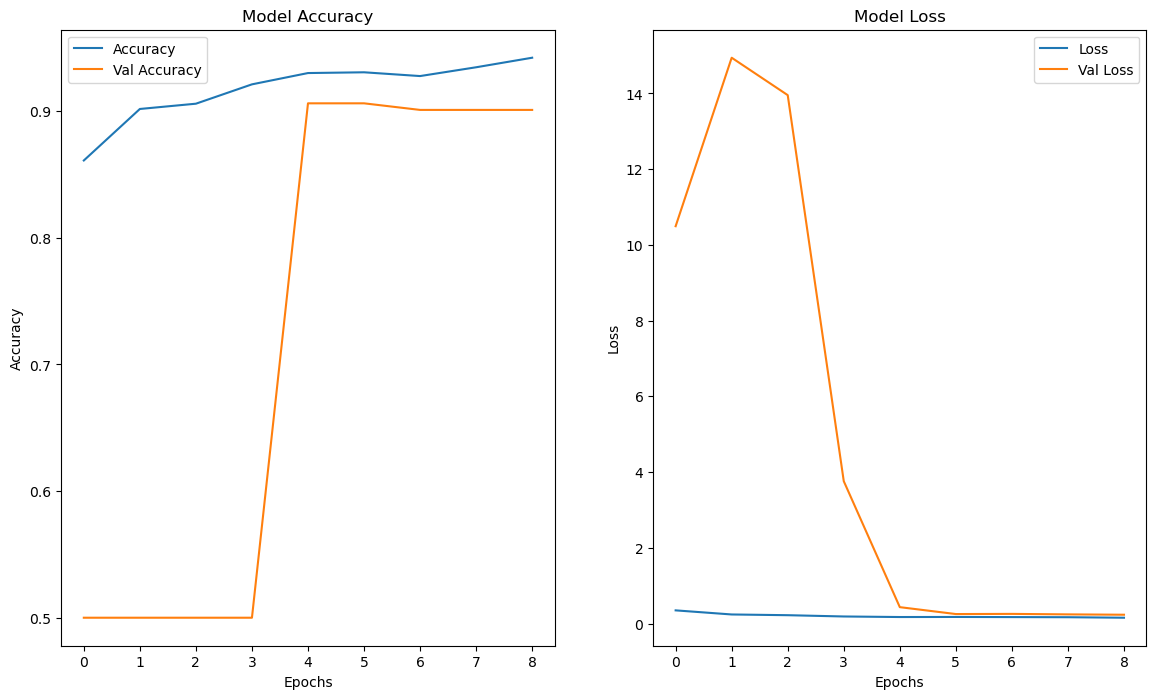

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model2_hist.history['accuracy'])
ax1.plot(model2_hist.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')

ax2.plot(model2_hist.history['loss'])
ax2.plot(model2_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# Model 3
While the performance has increased, we can see there is still some overfitting. It is also not quite clear why the validation accuracy is stagnant for the first 3 epochs, and the validation loss skyrockets during the first 1-2 epochs. 

What I will try next is to add more regularization and more data augmentation to help with overfitting. The images will also be scaled down to 150x150 to potentially help with learning speed.

In [23]:
#Change batch size depending on scenario
b_size = 16

train_data = ImageDataGenerator(rescale=1/255, rotation_range=35, zoom_range=0.25, horizontal_flip=True,
                                width_shift_range=0.25, height_shift_range=0.25)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(150,150), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(150, 150), batch_size=b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(150, 150), batch_size=b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


We will increase the dropout layers, and add a kernel regularizer to the dense function.

In [24]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3), groups=1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model3.add(Dropout(0.1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', groups=1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', groups=1))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(GlobalAveragePooling2D())
model3.add(Dense(units=64, activation='relu', kernel_regularizer=L2(0.01)))
model3.add(Dropout(0.4))
model3.add(Dense(units=1, activation='sigmoid'))

There are a few more things we are doing here. Clipnorm is being added to the Adam optimizer to prevent the gradient from exploding. The batch size has also been decreased so that there are more steps per epoch.

In [25]:
optimizer = keras.optimizers.Adam(lr=0.0001, clipnorm=1.0)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=1, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True , patience=3, verbose=1)

model3.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
with tf.device('/GPU:0'): #Don't think this is working properly, needs at least python 3.9
    model3_hist = model3.fit(train_img, 
                             epochs=10, 
                             validation_data=val_img, 
                             steps_per_epoch= 5040/b_size, 
                             callbacks=[reduce_lr, early_stop])

Epoch 1/10
315/315 [==============================] - 55s 170ms/step - loss: 1.0870 - accuracy: 0.8500 - val_loss: 3.4818 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/10
315/315 [==============================] - 54s 170ms/step - loss: 0.8907 - accuracy: 0.8732 - val_loss: 1.5123 - val_accuracy: 0.5469 - lr: 1.0000e-04
Epoch 3/10
315/315 [==============================] - 54s 171ms/step - loss: 0.7612 - accuracy: 0.8825 - val_loss: 1.0902 - val_accuracy: 0.6927 - lr: 1.0000e-04
Epoch 4/10
315/315 [==============================] - 53s 168ms/step - loss: 0.6396 - accuracy: 0.8996 - val_loss: 0.6994 - val_accuracy: 0.8646 - lr: 1.0000e-04
Epoch 5/10
315/315 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.8996
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
315/315 [==============================] - 54s 170ms/step - loss: 0.5731 - accuracy: 0.8996 - val_loss: 0.6889 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 6/10
315/315 [========

In [26]:
model3.evaluate(test_img)

39/39 [==============================] - 4s 99ms/step - loss: 0.6707 - accuracy: 0.8590


[0.6707213521003723, 0.8589743375778198]

Text(0.5, 1.0, 'Model Loss')

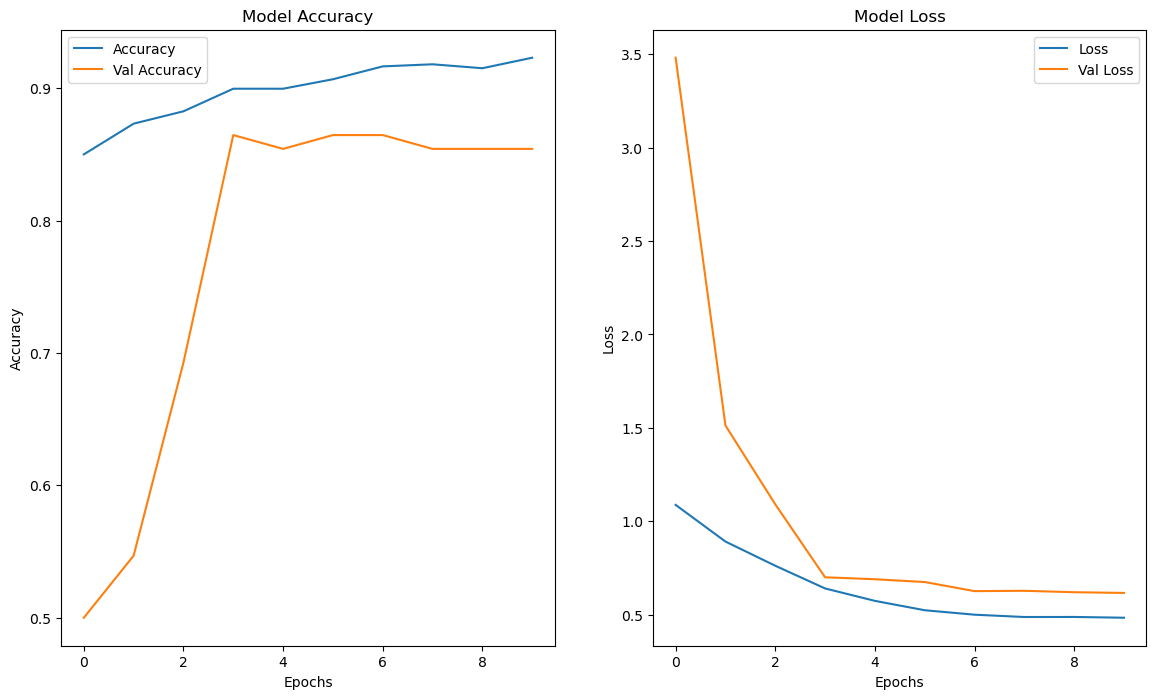

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model3_hist.history['accuracy'])
ax1.plot(model3_hist.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')

ax2.plot(model3_hist.history['loss'])
ax2.plot(model3_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

Unfortunately, even with all these changes, the model does not seem to be getting better at generalizing. There is still a sizeable gap between train and validation accuracy.

# Model 4
Now that a wall has been hit with my own model, I will explore using other models that have already been trained and perform extremely well. 

First, starting with VGG16. It turns out that adam optimizer does not work well with VGG16 so we will use SGD.

In [6]:
#Change batch size depending on scenario
b_size =  16

train_data = ImageDataGenerator(rescale=1/255, rotation_range=30, zoom_range=0.3, horizontal_flip=True,
                                width_shift_range=0.25, height_shift_range=0.25)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(150,150), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(150, 150), batch_size=b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(150, 150), batch_size=b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
model4 = Sequential()
model4.add(VGG16(include_top = False, pooling='max', weights='imagenet', input_shape=(150, 150, 3)))

model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=1, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True , patience=3, verbose=1)

optimizer = keras.optimizers.SGD(lr=0.0001, clipnorm=1.0)
model4.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])

c:\Users\Eddie\anaconda3\envs\gpuenv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
model4_hist = model4.fit(train_img, epochs=15, validation_data=val_img, steps_per_epoch=5040/b_size, callbacks=[early_stop])

Epoch 1/15
315/315 [==============================] - 54s 168ms/step - loss: 0.5674 - accuracy: 0.7419 - recall_1: 0.9786 - val_loss: 0.7083 - val_accuracy: 0.5000 - val_recall_1: 1.0000
Epoch 2/15
315/315 [==============================] - 51s 163ms/step - loss: 0.4972 - accuracy: 0.7534 - recall_1: 0.9997 - val_loss: 0.6415 - val_accuracy: 0.5156 - val_recall_1: 1.0000
Epoch 3/15
315/315 [==============================] - 51s 163ms/step - loss: 0.4404 - accuracy: 0.7734 - recall_1: 0.9976 - val_loss: 0.5354 - val_accuracy: 0.6094 - val_recall_1: 1.0000
Epoch 4/15
315/315 [==============================] - 52s 165ms/step - loss: 0.3934 - accuracy: 0.8058 - recall_1: 0.9884 - val_loss: 0.4167 - val_accuracy: 0.8281 - val_recall_1: 0.9792
Epoch 5/15
315/315 [==============================] - 51s 163ms/step - loss: 0.3376 - accuracy: 0.8508 - recall_1: 0.9723 - val_loss: 0.3270 - val_accuracy: 0.8906 - val_recall_1: 0.9583
Epoch 6/15
315/315 [==============================] - 52s 166ms/s

In [9]:
model4.evaluate(test_img)

39/39 [==============================] - 4s 98ms/step - loss: 0.2678 - accuracy: 0.8910 - recall_1: 0.9385


[0.267839640378952, 0.8910256624221802, 0.9384615421295166]

In [ ]:
preds = model4.predict(test_img)
cfm = confusion_matrix(test_img, preds)

315/315 [==============================] - 50s 158ms/step


Text(0.5, 1.0, 'Model Loss')

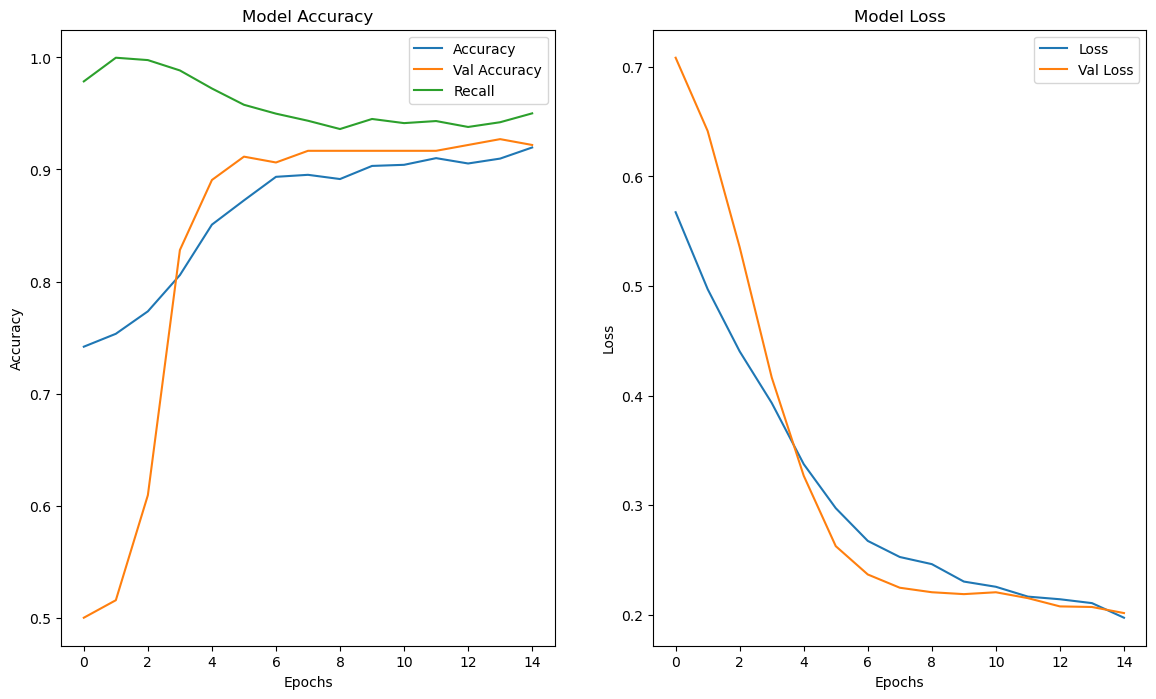

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model4_hist.history['accuracy'])
ax1.plot(model4_hist.history['val_accuracy'])
ax1.plot(model4_hist.history['recall_1'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy', 'Recall'])
ax1.set_title('Model Accuracy')

ax2.plot(model4_hist.history['loss'])
ax2.plot(model4_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# Grad-CAM Implementation

Grad cam is used to visualize where in the picture the model is determining which class it is. Grad cam will apply a heatmap to the picture, which we can then inspect to see if it is working properly.

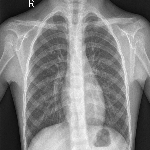

In [41]:
image = keras.utils.load_img('../data/test/NORMAL/IM-0001-0001.jpeg', target_size=(150,150))
image

In [42]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,780,481
Trainable params: 14,780,481
Non-trainable params: 0
_________________________________________________________________


In [43]:
"block5_conv3"

'block5_conv3'

In [44]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [50]:
import keras.preprocessing
img_arr = keras.utils.img_to_array(image)
make_gradcam_heatmap(img_arr, model4, "vgg16", ['flatten_1', 'dense_2', 'dense_3'])

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") at layer "block1_conv1". The following previous layers were accessed without issue: []